In [57]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import sympy as sp

plt.rcParams['font.size'] = 18
plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = [8,6]

# E3)
### a)

In [58]:
#Define the constants
C_1, C_2, C_c = 70, 72, 200
C_1c, C_2c, C_12 = 4, 4.2, 0.1
w_1, w_2 = 4, 4

eta = C_1c*C_2c/(C_12*C_c)

def sigma(w_c):
    return 1/(0.5*(1/(w_1+w_c) + 1/(w_2+w_c))) 

def delta(w_c):
    return 1/(0.5*(1/(w_1+-w_c) + 1/(w_2+-w_c))) 



In [59]:
def g(w_c):
    bracket = 0.5 * (w_c/(2*delta(w_c)) * eta - w_c/(2*sigma(w_c))*eta + eta + 1)
    other = C_12/np.sqrt(C_1*C_2) * np.sqrt(w_1*w_2)
    return bracket*other

g(6)

0.0009240353185031777

Text(0, 0.5, '$\\tilde{g}$ in $MHz$')

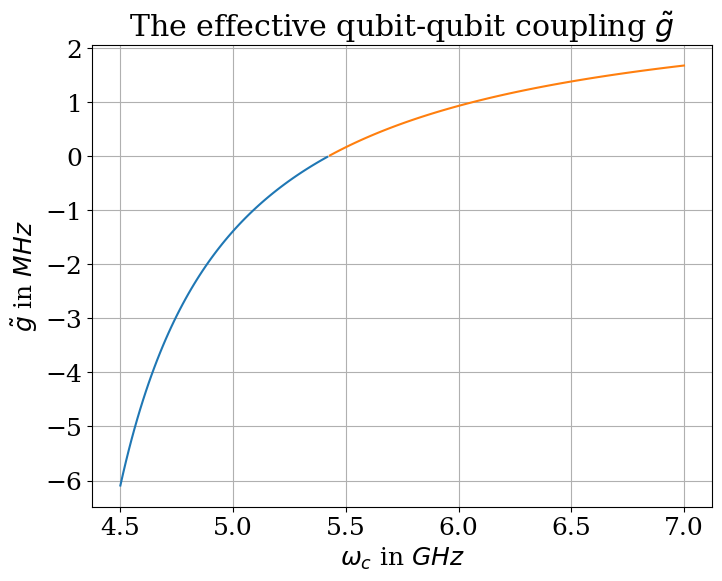

In [60]:
freq = np.linspace(4.5, 7, 200)
g_val = g(freq)*1e3

plt.plot(freq[g_val<0], g_val[g_val<0])
plt.plot(freq[g_val>0], g_val[g_val>0])

plt.title(r"The effective qubit-qubit coupling $\tilde{g}$")
plt.xlabel(r"$\omega_c$ in $GHz$")
plt.ylabel(r"$\tilde{g}$ in $MHz$")

In [61]:
#Finding the critical frequency

w_critcial = (max(freq[g_val<0])+min(freq[g_val>0]))/2

### b)

In [62]:
from scipy.integrate import solve_ivp

#Defining matrices
identity = np.array([[1, 0],[0, 1]]) 
sigma_z = np.array([[1, 0],[0, -1]])
sigma_plus = np.array([[0, 1],[0, 0]])
sigma_minus = np.array([[0, 0],[1, 0]])

def H(w_1, w_2, w_c, t):
    H1H2 =  0.5 * (w_1*np.kron(sigma_z, identity) + w_2*np.kron(identity, sigma_z))
    H_I = g(w_c)*(np.kron(sigma_plus, sigma_minus) + np.kron(sigma_minus, sigma_plus))
    return H1H2 + np.cos(t)*H_I

In [77]:
H(4, 4, 4.1, 0)

array([[ 4.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.04392715,  0.        ],
       [ 0.        , -0.04392715,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -4.        ]])

In [75]:
H_test = H(4, 4, 4.1, 0)

eigenvalues, eigenvectors = sc.linalg.eigh(H_test)

print(eigenvalues, eigenvectors)

[-4.         -0.04392715  0.04392715  4.        ] [[ 0.          0.          0.          1.        ]
 [ 0.          0.70710678 -0.70710678  0.        ]
 [ 0.          0.70710678  0.70710678  0.        ]
 [ 1.          0.          0.          0.        ]]


Assuming that we can instantanously switch $\omega_d$ then we can make $\tilde{g}$ constant in time and we get that the amount of time needed for a iSWAP gate is $\tau=1/4\tilde{g}$.

First we try with no coupling

In [72]:
initial = np.array([0,1,1,0], dtype=complex)/2

target_state = np.array([0,-1j,-1j,0], dtype=complex)/2

omega_d = 4.8

def H_t(t):
    return H(4, 4, omega_d, t)

def diff_equation(t, y):
    return - 1j * H_t(t)@y


time = (0,abs(1/(4*g(omega_d))))

#time = (0, 5)

results = solve_ivp(diff_equation, t_span=time, y0=initial, first_step=1/1000)

inital_proj = np.zeros_like(results.t)
final_proj = np.zeros_like(results.t)

for i in range(len(results.t)):
    inital_proj[i] = abs(initial@results.y[:,i])**2
    final_proj[i] = abs(target_state@results.y[:,i])**2



(0.0, 3.0)

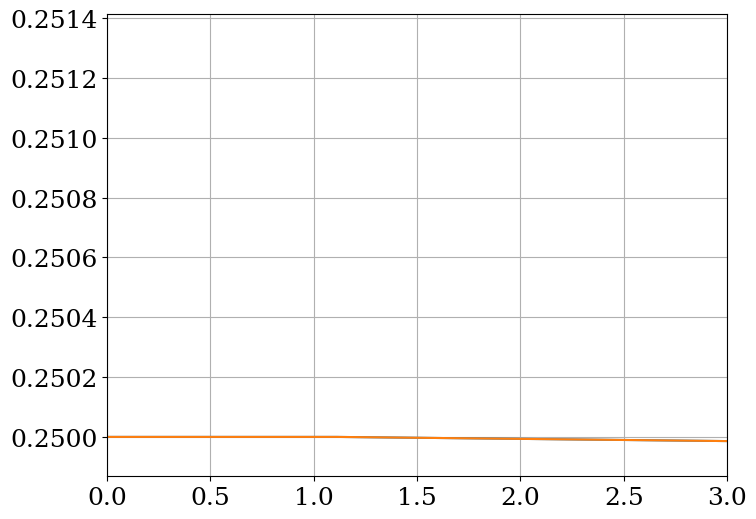

In [73]:
plt.plot(results.t, inital_proj)
plt.plot(results.t, final_proj)
plt.xlim(0,3)